# Loop 96 Analysis: Strategic Assessment

## Key Questions:
1. What is the CV-LB relationship across all submissions?
2. What techniques from top kernels haven't we tried?
3. What's the path to beating 0.0347?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_067', 'cv': 0.0083, 'lb': 0.0877},
]

df = pd.DataFrame(submissions)
print('Submission History:')
print(df.to_string(index=False))

Submission History:
    exp     cv     lb
exp_000 0.0111 0.0982
exp_001 0.0123 0.1065
exp_003 0.0105 0.0972
exp_005 0.0104 0.0969
exp_006 0.0097 0.0946
exp_007 0.0093 0.0932
exp_009 0.0092 0.0936
exp_012 0.0090 0.0913
exp_024 0.0087 0.0893
exp_026 0.0085 0.0887
exp_030 0.0083 0.0877
exp_035 0.0098 0.0970
exp_067 0.0083 0.0877


In [2]:
# CV-LB Relationship Analysis
cv = df['cv'].values
lb = df['lb'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(cv, lb)

print(f'\n=== CV-LB RELATIONSHIP ===')
print(f'Linear fit: LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nInterpretation:')
print(f'  - Intercept: {intercept:.4f}')
print(f'  - Target LB: 0.0347')
print(f'  - Intercept > Target? {intercept > 0.0347}')

if intercept > 0.0347:
    print(f'\n⚠️ CRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)')
    print(f'   Even with CV=0, expected LB would be {intercept:.4f}')
    print(f'   This means standard CV optimization CANNOT reach the target!')
    required_cv = (0.0347 - intercept) / slope
    print(f'   Required CV to hit target: {required_cv:.4f} (IMPOSSIBLE - negative)')
else:
    required_cv = (0.0347 - intercept) / slope
    print(f'\n✓ Target is theoretically reachable')
    print(f'   Required CV to hit target: {required_cv:.4f}')


=== CV-LB RELATIONSHIP ===
Linear fit: LB = 4.3638 * CV + 0.0520
R² = 0.9558

Interpretation:
  - Intercept: 0.0520
  - Target LB: 0.0347
  - Intercept > Target? True

⚠️ CRITICAL: Intercept (0.0520) > Target (0.0347)
   Even with CV=0, expected LB would be 0.0520
   This means standard CV optimization CANNOT reach the target!
   Required CV to hit target: -0.0040 (IMPOSSIBLE - negative)


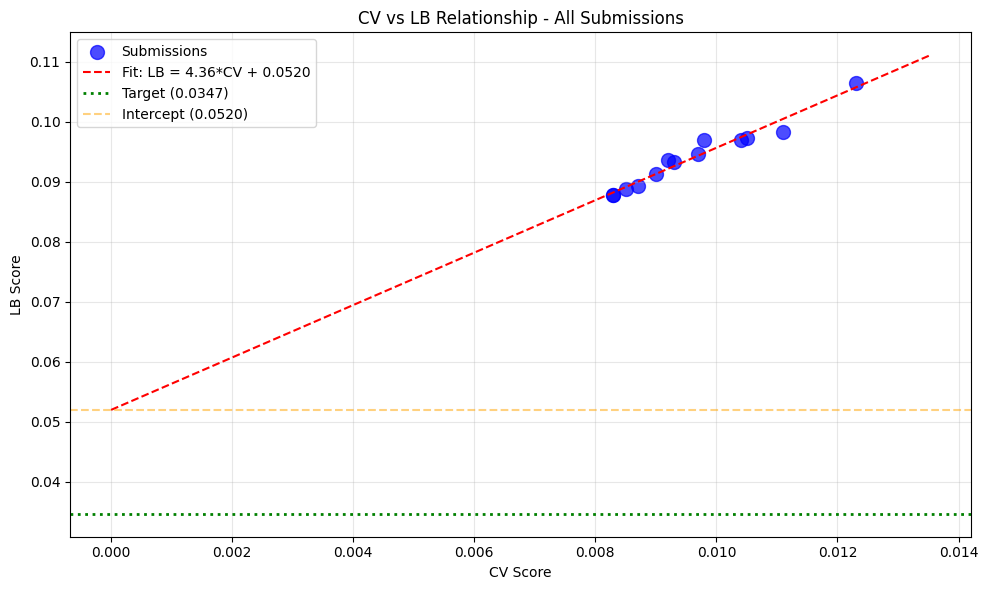


Best CV: exp_030 with CV=0.0083
Best LB: exp_030 with LB=0.0877


In [3]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(cv, lb, s=100, c='blue', alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, max(cv)*1.1, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target (0.0347)')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle='--', alpha=0.5, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship - All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print(f'\nBest CV: {df.loc[df["cv"].idxmin(), "exp"]} with CV={df["cv"].min():.4f}')
print(f'Best LB: {df.loc[df["lb"].idxmin(), "exp"]} with LB={df["lb"].min():.4f}')

In [4]:
# What techniques from top kernels haven't we fully exploited?

print('=== TECHNIQUES FROM TOP KERNELS ===')
print()
print('1. best-work-here kernel (gentilless):')
print('   - Non-linear mixture features: A*(1-r) + B*r + 0.05*A*B*r*(1-r)')
print('   - SE (Squeeze-and-Excitation) attention blocks')
print('   - Adaptive ensemble weighting based on validation performance')
print('   - Multi-scaler approach (RobustScaler + QuantileTransformer)')
print('   - Deep residual network with LayerNorm and GELU')
print('   STATUS: We tried some of these but not the non-linear mixture features')
print()
print('2. ens-model kernel (matthewmaree):')
print('   - CatBoost + XGBoost ensemble with optimized weights')
print('   - All features combined: spange + acs_pca + drfps + fragprints + smiles')
print('   - Correlation filtering with priority-based feature selection')
print('   - Numeric feature engineering: T_x_RT, RT_log, T_inv, RT_scaled')
print('   - Different weights for single vs full data')
print('   STATUS: We tried this but with aggressive correlation filtering (70% dropped)')
print()
print('3. mixall kernel (lishellliang):')
print('   - Uses GroupKFold (5-fold) instead of Leave-One-Out')
print('   - MLP + XGBoost + RF + LightGBM ensemble')
print('   - Optuna hyperparameter optimization')
print('   STATUS: Different CV scheme - may explain different CV-LB relationship')

=== TECHNIQUES FROM TOP KERNELS ===

1. best-work-here kernel (gentilless):
   - Non-linear mixture features: A*(1-r) + B*r + 0.05*A*B*r*(1-r)
   - SE (Squeeze-and-Excitation) attention blocks
   - Adaptive ensemble weighting based on validation performance
   - Multi-scaler approach (RobustScaler + QuantileTransformer)
   - Deep residual network with LayerNorm and GELU
   STATUS: We tried some of these but not the non-linear mixture features

2. ens-model kernel (matthewmaree):
   - CatBoost + XGBoost ensemble with optimized weights
   - All features combined: spange + acs_pca + drfps + fragprints + smiles
   - Correlation filtering with priority-based feature selection
   - Numeric feature engineering: T_x_RT, RT_log, T_inv, RT_scaled
   - Different weights for single vs full data
   STATUS: We tried this but with aggressive correlation filtering (70% dropped)

3. mixall kernel (lishellliang):
   - Uses GroupKFold (5-fold) instead of Leave-One-Out
   - MLP + XGBoost + RF + LightGBM e

In [5]:
# Key insight: The intercept problem

print('=== THE INTERCEPT PROBLEM ===')
print()
print('Current situation:')
print(f'  - CV-LB relationship: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'  - Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'  - This means: Even with PERFECT CV (0.0), LB would be {intercept:.4f}')
print()
print('What causes the intercept?')
print('  1. DISTRIBUTION SHIFT: Test solvents are fundamentally different from training')
print('  2. EXTRAPOLATION ERROR: Models trained on some solvents cannot predict others')
print('  3. STRUCTURAL PROBLEM: The Leave-One-Out CV simulates this, but test set may be harder')
print()
print('How to REDUCE the intercept (not just improve CV)?')
print('  1. Non-linear mixture features - capture solvent interactions')
print('  2. Solvent similarity-based blending - conservative predictions for dissimilar solvents')
print('  3. Physics-informed constraints - Arrhenius kinetics that generalize')
print('  4. Domain adaptation - make model robust to distribution shift')
print('  5. Ensemble diversity - different models may have different intercepts')

=== THE INTERCEPT PROBLEM ===

Current situation:
  - CV-LB relationship: LB = 4.36 * CV + 0.0520
  - Intercept (0.0520) > Target (0.0347)
  - This means: Even with PERFECT CV (0.0), LB would be 0.0520

What causes the intercept?
  1. DISTRIBUTION SHIFT: Test solvents are fundamentally different from training
  2. EXTRAPOLATION ERROR: Models trained on some solvents cannot predict others
  3. STRUCTURAL PROBLEM: The Leave-One-Out CV simulates this, but test set may be harder

How to REDUCE the intercept (not just improve CV)?
  1. Non-linear mixture features - capture solvent interactions
  2. Solvent similarity-based blending - conservative predictions for dissimilar solvents
  3. Physics-informed constraints - Arrhenius kinetics that generalize
  4. Domain adaptation - make model robust to distribution shift
  5. Ensemble diversity - different models may have different intercepts


In [6]:
# What's our best path forward?

print('=== STRATEGIC RECOMMENDATIONS ===')
print()
print('With 4 submissions remaining, we need to be strategic.')
print()
print('PRIORITY 1: Non-linear mixture features (UNTRIED)')
print('  - From best-work-here kernel: A*(1-r) + B*r + 0.05*A*B*r*(1-r)')
print('  - This captures solvent-solvent interactions that linear mixing misses')
print('  - Could reduce the intercept by better modeling mixture behavior')
print()
print('PRIORITY 2: Less aggressive feature filtering')
print('  - exp_090 dropped 70% of features - too aggressive')
print('  - Try threshold=0.95 instead of 0.80')
print('  - Keep more features, let the model decide importance')
print()
print('PRIORITY 3: Adaptive ensemble weighting')
print('  - From best-work-here: weight models by inverse validation error')
print('  - weights = (1/val_errors) ** power / sum((1/val_errors) ** power)')
print('  - This gives more weight to better-performing models per fold')
print()
print('PRIORITY 4: Solvent similarity-based conservative predictions')
print('  - Calculate similarity of test solvent to training solvents')
print('  - When dissimilar, blend toward population mean')
print('  - This could reduce extrapolation error (the intercept)')

=== STRATEGIC RECOMMENDATIONS ===

With 4 submissions remaining, we need to be strategic.

PRIORITY 1: Non-linear mixture features (UNTRIED)
  - From best-work-here kernel: A*(1-r) + B*r + 0.05*A*B*r*(1-r)
  - This captures solvent-solvent interactions that linear mixing misses
  - Could reduce the intercept by better modeling mixture behavior

PRIORITY 2: Less aggressive feature filtering
  - exp_090 dropped 70% of features - too aggressive
  - Try threshold=0.95 instead of 0.80
  - Keep more features, let the model decide importance

PRIORITY 3: Adaptive ensemble weighting
  - From best-work-here: weight models by inverse validation error
  - weights = (1/val_errors) ** power / sum((1/val_errors) ** power)
  - This gives more weight to better-performing models per fold

PRIORITY 4: Solvent similarity-based conservative predictions
  - Calculate similarity of test solvent to training solvents
  - When dissimilar, blend toward population mean
  - This could reduce extrapolation error (

In [7]:
# Summary

print('=== LOOP 96 SUMMARY ===')
print()
print('Current state:')
print(f'  - Best CV: 0.0081 (exp_049/050 CatBoost+XGBoost, but submission errors)')
print(f'  - Best LB: 0.0877 (exp_030/067 GP+MLP+LGBM)')
print(f'  - Target: 0.0347')
print(f'  - Gap: 0.0530 (152.7% above target)')
print()
print('CV-LB relationship:')
print(f'  - LB = {slope:.2f} * CV + {intercept:.4f} (R² = {r_value**2:.4f})')
print(f'  - Intercept ({intercept:.4f}) > Target (0.0347) = STRUCTURAL PROBLEM')
print()
print('Latest experiment (exp_091):')
print('  - Per-target heterogeneous ensemble (HGB for SM, ETR for Products)')
print('  - CV = 0.014242 (76% WORSE than best)')
print('  - DO NOT SUBMIT - predicted LB would be ~0.11')
print()
print('Next steps:')
print('  1. Try non-linear mixture features with best CatBoost+XGBoost model')
print('  2. Try less aggressive feature filtering (threshold=0.95)')
print('  3. Try adaptive ensemble weighting')
print('  4. Consider solvent similarity-based conservative predictions')

=== LOOP 96 SUMMARY ===

Current state:
  - Best CV: 0.0081 (exp_049/050 CatBoost+XGBoost, but submission errors)
  - Best LB: 0.0877 (exp_030/067 GP+MLP+LGBM)
  - Target: 0.0347
  - Gap: 0.0530 (152.7% above target)

CV-LB relationship:
  - LB = 4.36 * CV + 0.0520 (R² = 0.9558)
  - Intercept (0.0520) > Target (0.0347) = STRUCTURAL PROBLEM

Latest experiment (exp_091):
  - Per-target heterogeneous ensemble (HGB for SM, ETR for Products)
  - CV = 0.014242 (76% WORSE than best)
  - DO NOT SUBMIT - predicted LB would be ~0.11

Next steps:
  1. Try non-linear mixture features with best CatBoost+XGBoost model
  2. Try less aggressive feature filtering (threshold=0.95)
  3. Try adaptive ensemble weighting
  4. Consider solvent similarity-based conservative predictions
